<a href="https://colab.research.google.com/github/Nikhil4002-50-82/IIT-Assignment/blob/main/iit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload an image : 


Saving eg4.webp to eg4.webp


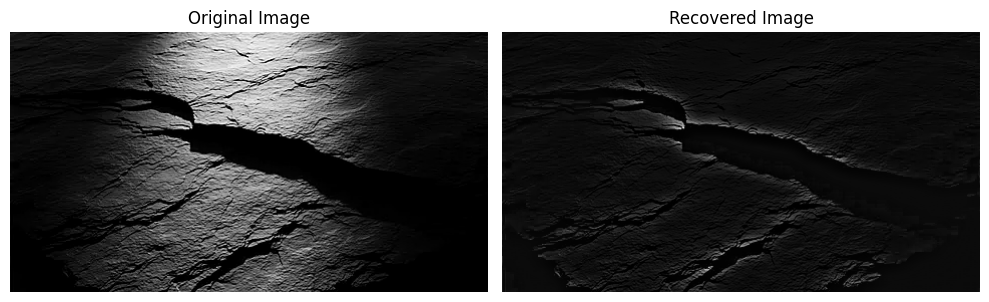

In [ ]:
#Histogram Equalization cannot distinguish whether a pixel is bright because the surface is intrinsically bright.
#It is a purely statistical technique and cannot mathematically isolate the multiplicative components R and L.
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def recoverImage(inputGray):
    logImage = np.log(inputGray + 1e-6)
    kernelSize = 25
    kernel = np.ones((kernelSize, kernelSize)) / (kernelSize**2)
    logIllumination = convolve(logImage, kernel, mode='reflect')
    logReflectance = logImage - logIllumination
    reflectance = np.exp(logReflectance)
    reflectanceNormalized = (reflectance - np.min(reflectance)) / (np.max(reflectance) - np.min(reflectance))
    return reflectanceNormalized

print("Upload an image : ")
uploadedFiles = files.upload()

if uploadedFiles:
    fileName = next(iter(uploadedFiles))
    fileData = uploadedFiles[fileName]
    imageStream = io.BytesIO(fileData)
    imgPIL = Image.open(imageStream)
    imgGray = imgPIL.convert('L')
    imgArray = np.array(imgGray)
    inputSample = imgArray.astype(float) / 255.0
    inputSample = np.clip(inputSample, 0.01, 1.0)
    recoveredReflectance = recoverImage(inputSample)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(inputSample, cmap='gray')
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    axes[1].imshow(recoveredReflectance, cmap='gray')
    axes[1].set_title('Recovered Image', fontsize=12)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

else:
    print("Image upload failed")


Upload checkerboard image:


Saving eg2.jpg to eg2.jpg
Corners detected successfully for eg2.jpg.


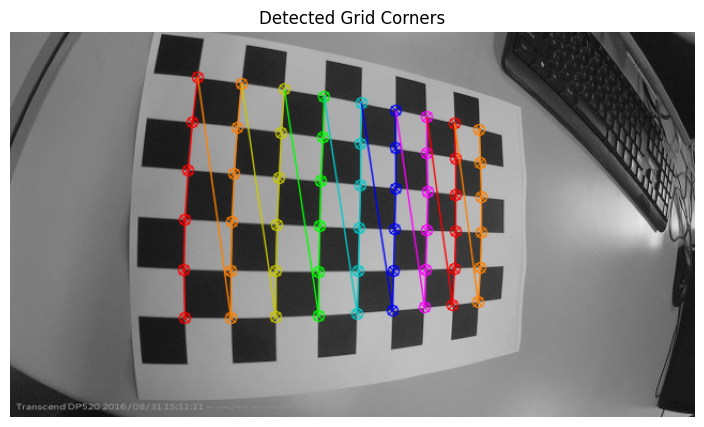

Estimating parameters and distortion
Estimated Focal Lengths (fx, fy): 438.09, 433.96
Estimated Principal Point (cx, cy): 316.58, 161.49
Estimated Radial Distortion (k1, k2): -0.443978, 0.202300


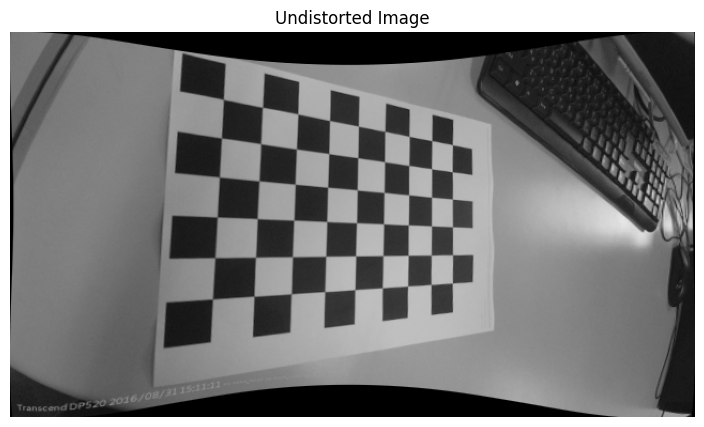

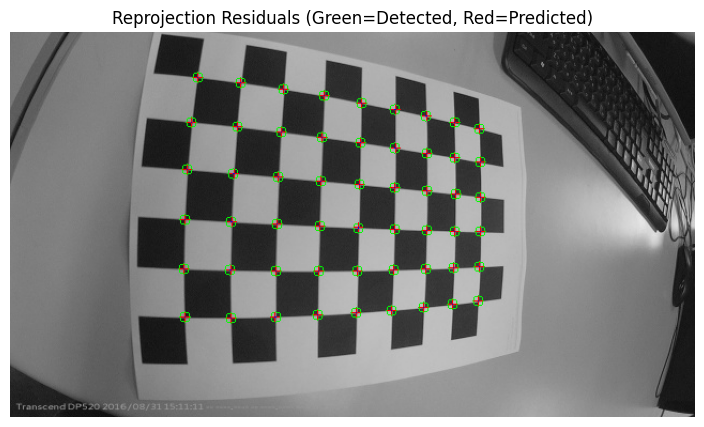

RMS Reprojection Error: 0.0175 pixels


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

checkerboardSize = (6, 9)
squareSizeMm = 20.0
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objectPointsTemplate = np.zeros((checkerboardSize[0] * checkerboardSize[1], 3), np.float32)
objectPointsTemplate[:, :2] = np.mgrid[0:checkerboardSize[0], 0:checkerboardSize[1]].T.reshape(-1, 2) * squareSizeMm
objectPoints = [objectPointsTemplate]
imagePoints = []
print("Upload checkerboard image:")
uploadedFiles = files.upload()
if uploadedFiles:
    fileName = next(iter(uploadedFiles))
    imageData = uploadedFiles[fileName]
    imageStream = io.BytesIO(imageData)
    imagePIL = Image.open(imageStream).convert('RGB')
    imageBgr = cv2.cvtColor(np.array(imagePIL), cv2.COLOR_RGB2BGR)
    grayImage = cv2.cvtColor(imageBgr, cv2.COLOR_BGR2GRAY)
    height, width = grayImage.shape[:2]
    foundCorners, corners = cv2.findChessboardCorners(grayImage, checkerboardSize, None)
    if foundCorners:
        print(f"Corners detected successfully for {fileName}.")
        refinedCorners = cv2.cornerSubPix(grayImage, corners, (11, 11), (-1, -1), criteria)
        imagePoints.append(refinedCorners)
        drawnImage = cv2.drawChessboardCorners(imageBgr.copy(), checkerboardSize, refinedCorners, foundCorners)
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(drawnImage, cv2.COLOR_BGR2RGB))
        plt.title('Detected Grid Corners')
        plt.axis('off')
        plt.show()
        print("Estimating parameters and distortion")
        success, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
            objectPoints,
            imagePoints,
            (width, height),
            None,
            None,
            flags=cv2.CALIB_FIX_K3 + cv2.CALIB_ZERO_TANGENT_DIST
        )
        k1, k2 = distCoeffs[0][0], distCoeffs[0][1]
        print(f"Estimated Focal Lengths (fx, fy): {cameraMatrix[0,0]:.2f}, {cameraMatrix[1,1]:.2f}")
        print(f"Estimated Principal Point (cx, cy): {cameraMatrix[0,2]:.2f}, {cameraMatrix[1,2]:.2f}")
        print(f"Estimated Radial Distortion (k1, k2): {k1:.6f}, {k2:.6f}")
        newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (width, height), 1, (width, height))
        undistortedImage = cv2.undistort(imageBgr, cameraMatrix, distCoeffs, None, newCameraMatrix)
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2RGB))
        plt.title('Undistorted Image')
        plt.axis('off')
        plt.show()
        reprojectedPoints, _ = cv2.projectPoints(objectPointsTemplate, rvecs[0], tvecs[0], cameraMatrix, distCoeffs)
        reprojectedPoints = reprojectedPoints.reshape(-1, 2)
        reprojectionError = cv2.norm(refinedCorners.reshape(-1, 2), reprojectedPoints, cv2.NORM_L2) / len(reprojectedPoints)
        residualImage = imageBgr.copy()
        for detected, predicted in zip(refinedCorners.reshape(-1, 2), reprojectedPoints):
            cv2.circle(residualImage, (int(detected[0]), int(detected[1])), 5, (0, 255, 0), 1)
            cv2.drawMarker(residualImage, (int(predicted[0]), int(predicted[1])), (0, 0, 255), cv2.MARKER_CROSS, 8, 1)
            cv2.line(residualImage, (int(detected[0]), int(detected[1])), (int(predicted[0]), int(predicted[1])), (255, 0, 0), 1)

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(residualImage, cv2.COLOR_BGR2RGB))
        plt.title('Reprojection Residuals (Green=Detected, Red=Predicted)')
        plt.axis('off')
        plt.show()
        print(f"RMS Reprojection Error: {reprojectionError:.4f} pixels")
    else:
        print(f"Could not detect a {checkerboardSize[0]}x{checkerboardSize[1]} grid. Please check parameters and re-upload.")
else:
    print("Image Upload Failed. Please try again.")


In [ ]:
import os
import io
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

baseDir = '/content/drive/MyDrive/aksharantar_sampled'
lang = 'hin'
trainPath = os.path.join(baseDir, lang, f'{lang}_train.csv')
validPath = os.path.join(baseDir, lang, f'{lang}_valid.csv')
testPath = os.path.join(baseDir, lang, f'{lang}_test.csv')
if not (os.path.exists(trainPath) and os.path.exists(validPath) and os.path.exists(testPath)):
    raise FileNotFoundError("One or more dataset files missing. Check baseDir and lang variables.")

trainDf = pd.read_csv(trainPath, header=0)
validDf = pd.read_csv(validPath, header=0)
testDf = pd.read_csv(testPath, header=0)

trainPairs = list(zip(trainDf.iloc[:,0].astype(str).tolist(), trainDf.iloc[:,1].astype(str).tolist()))
validPairs = list(zip(validDf.iloc[:,0].astype(str).tolist(), validDf.iloc[:,1].astype(str).tolist()))
testPairs = list(zip(testDf.iloc[:,0].astype(str).tolist(), testDf.iloc[:,1].astype(str).tolist()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedDim = 128
hiddenDim = 256
encoderLayers = 1
decoderLayers = 1
rnnType = 'GRU'
batchSize = 64
learningRate = 1e-3
epochs = 20
teacherForcingRatio = 0.5
modelSavePath = f'/content/drive/MyDrive/akshantar_models/{lang}_seq2seq.pth'
os.makedirs(os.path.dirname(modelSavePath), exist_ok=True)

class Vocab:
    def __init__(self, chars, name):
        self.name = name
        self.charToIndex = {"<PAD>":0,"<SOS>":1,"<EOS>":2}
        self.indexToChar = {0:"<PAD>",1:"<SOS>",2:"<EOS>"}
        self.size = len(self.charToIndex)
        for c in sorted(list(chars)):
            self.addChar(c)
    def addChar(self, char):
        if char not in self.charToIndex:
            self.charToIndex[char] = self.size
            self.indexToChar[self.size] = char
            self.size += 1

def buildVocabs(pairs):
    srcChars = set(c for s,t in pairs for c in s)
    tgtChars = set(c for s,t in pairs for c in t)
    srcVocab = Vocab(srcChars, "latin")
    tgtVocab = Vocab(tgtChars, "native")
    return srcVocab, tgtVocab

combinedPairs = trainPairs + validPairs + testPairs
srcVocab, tgtVocab = buildVocabs(trainPairs)

maxSrcLen = max(len(s) for s,t in combinedPairs) + 1
maxTgtLen = max(len(t) for s,t in combinedPairs) + 2

class TransliterationDataset(Dataset):
    def __init__(self, pairs, srcV, tgtV, maxSrcLen, maxTgtLen):
        self.pairs = pairs
        self.srcV = srcV
        self.tgtV = tgtV
        self.maxSrcLen = maxSrcLen
        self.maxTgtLen = maxTgtLen
    def __len__(self):
        return len(self.pairs)
    def encodeSrc(self, s):
        inds = [self.srcV.charToIndex.get(c, self.srcV.charToIndex["<PAD>"]) for c in s]
        inds.append(self.srcV.charToIndex["<EOS>"])
        pad = [self.srcV.charToIndex["<PAD>"]] * (self.maxSrcLen - len(inds))
        inds.extend(pad)
        return torch.tensor(inds, dtype=torch.long)
    def encodeTgt(self, t):
        inds = [self.tgtV.charToIndex["<SOS>"]] + [self.tgtV.charToIndex.get(c, self.tgtV.charToIndex["<PAD>"]) for c in t] + [self.tgtV.charToIndex["<EOS>"]]
        pad = [self.tgtV.charToIndex["<PAD>"]] * (self.maxTgtLen - len(inds))
        inds.extend(pad)
        return torch.tensor(inds, dtype=torch.long)
    def __getitem__(self, idx):
        s,t = self.pairs[idx]
        return self.encodeSrc(s).to(device), self.encodeTgt(t).to(device)

trainDataset = TransliterationDataset(trainPairs, srcVocab, tgtVocab, maxSrcLen, maxTgtLen)
validDataset = TransliterationDataset(validPairs, srcVocab, tgtVocab, maxSrcLen, maxTgtLen)
testDataset = TransliterationDataset(testPairs, srcVocab, tgtVocab, maxSrcLen, maxTgtLen)

trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)

class Encoder(nn.Module):
    def __init__(self, inputVocabSize, embedDim, hiddenDim, numLayers, rnnType):
        super().__init__()
        self.embedding = nn.Embedding(inputVocabSize, embedDim, padding_idx=0)
        if rnnType == 'GRU':
            self.rnn = nn.GRU(embedDim, hiddenDim, numLayers, batch_first=True)
        elif rnnType == 'LSTM':
            self.rnn = nn.LSTM(embedDim, hiddenDim, numLayers, batch_first=True)
        else:
            self.rnn = nn.RNN(embedDim, hiddenDim, numLayers, batch_first=True)
    def forward(self, src):
        emb = self.embedding(src)
        outputs, hidden = self.rnn(emb)
        return hidden

class Decoder(nn.Module):
    def __init__(self, outputVocabSize, embedDim, hiddenDim, numLayers, rnnType):
        super().__init__()
        self.embedding = nn.Embedding(outputVocabSize, embedDim, padding_idx=0)
        if rnnType == 'GRU':
            self.rnn = nn.GRU(embedDim, hiddenDim, numLayers, batch_first=True)
        elif rnnType == 'LSTM':
            self.rnn = nn.LSTM(embedDim, hiddenDim, numLayers, batch_first=True)
        else:
            self.rnn = nn.RNN(embedDim, hiddenDim, numLayers, batch_first=True)
        self.out = nn.Linear(hiddenDim, outputVocabSize)
    def forward(self, inputChar, hidden):
        emb = self.embedding(inputChar)
        output, hidden = self.rnn(emb, hidden)
        pred = self.out(output[:,0,:])
        return pred, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, targetVocabSize):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.targetVocabSize = targetVocabSize
    def forward(self, src, tgt, teacherForcingRatio=0.5):
        batchSize = src.shape[0]
        maxTgt = tgt.shape[1]
        outputs = torch.zeros(batchSize, maxTgt, self.targetVocabSize, device=device)
        encHidden = self.encoder(src)
        decHidden = encHidden
        decInput = tgt[:,0].unsqueeze(1)
        for t in range(1, maxTgt):
            out, decHidden = self.decoder(decInput, decHidden)
            outputs[:,t,:] = out
            teacherForce = random.random() < teacherForcingRatio
            top1 = out.argmax(1)
            decInput = tgt[:,t].unsqueeze(1) if teacherForce else top1.unsqueeze(1)
        return outputs

def initWeights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

encoder = Encoder(srcVocab.size, embedDim, hiddenDim, encoderLayers, rnnType).to(device)
decoder = Decoder(tgtVocab.size, embedDim, hiddenDim, decoderLayers, rnnType).to(device)
model = Seq2Seq(encoder, decoder, tgtVocab.size).to(device)
model.apply(initWeights)

optimizer = optim.Adam(model.parameters(), lr=learningRate)
criterion = nn.CrossEntropyLoss(ignore_index=tgtVocab.charToIndex["<PAD>"])

def trainEpoch(model, loader, optimizer, criterion, clip):
    model.train()
    totalLoss = 0
    for src, tgt in loader:
        optimizer.zero_grad()
        output = model(src, tgt, teacherForcingRatio)
        outputDim = output.shape[-1]
        outputFlat = output[:,1:,:].reshape(-1, outputDim)
        targetFlat = tgt[:,1:].reshape(-1)
        loss = criterion(outputFlat, targetFlat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        totalLoss += loss.item()
    return totalLoss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    totalLoss = 0
    with torch.no_grad():
        for src, tgt in loader:
            output = model(src, tgt, 0.0)
            outputDim = output.shape[-1]
            outputFlat = output[:,1:,:].reshape(-1, outputDim)
            targetFlat = tgt[:,1:].reshape(-1)
            loss = criterion(outputFlat, targetFlat)
            totalLoss += loss.item()
    return totalLoss / len(loader)

for epoch in range(1, epochs+1):
    trainLoss = trainEpoch(model, trainLoader, optimizer, criterion, clip=1)
    validLoss = evaluate(model, validLoader, criterion)
    print(f'Epoch {epoch:02d} | Train Loss: {trainLoss:.4f} | Valid Loss: {validLoss:.4f}')
    torch.save({'epoch':epoch,'model_state':model.state_dict(),'optimizer_state':optimizer.state_dict()}, modelSavePath)

def infer(model, srcText, srcV, tgtV, maxTgtLen):
    model.eval()
    with torch.no_grad():
        srcIdx = [srcV.charToIndex.get(c, srcV.charToIndex["<PAD>"]) for c in srcText] + [srcV.charToIndex["<EOS>"]]
        pad = [srcV.charToIndex["<PAD>"]] * (maxSrcLen - len(srcIdx))
        srcIdx.extend(pad)
        srcTensor = torch.tensor(srcIdx, dtype=torch.long, device=device).unsqueeze(0)
        encHidden = model.encoder(srcTensor)
        decHidden = encHidden
        decInput = torch.tensor([[tgtV.charToIndex["<SOS>"]]], dtype=torch.long, device=device)
        preds = []
        for _ in range(maxTgtLen):
            out, decHidden = model.decoder(decInput, decHidden)
            top1 = out.argmax(1)
            ch = tgtV.indexToChar[top1.item()]
            if ch == "<EOS>" or ch == "<PAD>":
                break
            preds.append(ch)
            decInput = top1.unsqueeze(1)
        return "".join(preds)

print("\nSample predictions on test set:")
for i in range(10):
    s,t = testPairs[i]
    pred = infer(model, s, srcVocab, tgtVocab, maxTgtLen)
    print(f'Input: {s:<12} | Target: {t:<12} | Pred: {pred:<12}')

def testAccuracy(model, loader, tgtV):
    model.eval()
    totalTokens = 0
    correctTokens = 0
    with torch.no_grad():
        for src, tgt in loader:
            output = model(src, tgt, 0.0)
            preds = output.argmax(-1)
            tgtFlat = tgt[:,1:]
            predsFlat = preds[:,1:]
            mask = tgtFlat != tgtV.charToIndex["<PAD>"]
            totalTokens += mask.sum().item()
            correctTokens += ((predsFlat == tgtFlat) & mask).sum().item()
    return correctTokens / totalTokens if totalTokens>0 else 0.0

acc = testAccuracy(model, testLoader, tgtVocab)
print(f'\nTest token-level accuracy: {acc*100:.2f}%')


Mounted at /content/drive
Epoch 01 | Train Loss: 2.6643 | Valid Loss: 2.0379
Epoch 02 | Train Loss: 1.4867 | Valid Loss: 1.4284
Epoch 03 | Train Loss: 1.1053 | Valid Loss: 1.2767
Epoch 04 | Train Loss: 0.9417 | Valid Loss: 1.2115
Epoch 05 | Train Loss: 0.8544 | Valid Loss: 1.1630
Epoch 06 | Train Loss: 0.7851 | Valid Loss: 1.1079
Epoch 07 | Train Loss: 0.7331 | Valid Loss: 1.1214
Epoch 08 | Train Loss: 0.6937 | Valid Loss: 1.1118
Epoch 09 | Train Loss: 0.6573 | Valid Loss: 1.0949
Epoch 10 | Train Loss: 0.6254 | Valid Loss: 1.1106
Epoch 11 | Train Loss: 0.5939 | Valid Loss: 1.1176
Epoch 12 | Train Loss: 0.5643 | Valid Loss: 1.1169
Epoch 13 | Train Loss: 0.5468 | Valid Loss: 1.1132
Epoch 14 | Train Loss: 0.5170 | Valid Loss: 1.1349
Epoch 15 | Train Loss: 0.5028 | Valid Loss: 1.1200
Epoch 16 | Train Loss: 0.4798 | Valid Loss: 1.1700
Epoch 17 | Train Loss: 0.4650 | Valid Loss: 1.1497
Epoch 18 | Train Loss: 0.4478 | Valid Loss: 1.1721
Epoch 19 | Train Loss: 0.4352 | Valid Loss: 1.2102
Epoch